In [1]:
import numpy as np
import pandas as pd
import matplotlib 
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style 

# Defining Functions

In [2]:
def normalise(X):
    max_X = np.max(X)
    X_norm = X/max_X
    
    return X_norm

In [3]:
def one_hot(Y):
    m = Y.shape[0]
    n = np.unique(Y).shape[0]
    Y_hot = np.zeros((m,n))
    for i in range(m):
        Y_hot[i][Y[i]] = 1
    return Y_hot.T

In [4]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def softmax(x):
    e_x = np.exp(x)
    return e_x/np.sum(e_x, axis=0, keepdims = True)

def relu(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

def derivative_relu(x):
    return np.array(x > 0, dtype='float')

def derivative_tanh(x):
    return 1-(x**2)

In [5]:
def initialise_parameters(layer_dims):
    L = len(layer_dims) - 1
    parameters = {}
    for i in range(1,L+1):
        #parameters["w"+ str(i)] = np.zeros((layer_dims[i], layer_dims[i-1]))
        parameters["w"+ str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1])/np.sqrt(layer_dims[i-1])
        parameters["b"+ str(i)] = np.zeros((layer_dims[i], 1))
        
    return parameters

In [6]:
def forward_prop(X, parameters, activation):
    L = len(parameters)//2
    Al = {}
    Al["A0"] = X
    for l in range(1,L):
        Al["Z"+ str(l)] = parameters['w'+ str(l)].dot(Al['A' + str(l-1)]) + parameters["b"+ str(l)]
        if activation == 'relu':
            Al["A"+ str(l)] = relu(Al["Z"+ str(l)])
        elif activation == 'tanh':
            Al["A"+ str(l)] = tanh(Al["Z"+ str(l)])
        else:
            print("THE GIVEN ACTIVATION FUNCTION IS NOT SUPPORTED.")
    
    Al["Z"+ str(L)] =  np.dot(parameters["w"+ str(L)], Al["A"+ str(L-1)]) + parameters["b"+ str(L)]
    if Al["Z"+ str(L)].shape[0] == 1:
        Al["A"+ str(L)] = sigmoid(Al["Z"+ str(L)])
    else:
        Al["A"+ str(L)] = softmax(Al["Z"+ str(L)])
    
    return Al["A"+ str(L)], Al

In [7]:
def cost(AL, Y):
    m = Y.shape[1]
    if Y.shape[0] == 1:
        cost = -(1/m)*np.sum((Y*np.log(AL)) + ((1 - Y)*np.log(1 - AL)))
    else:
        cost = -(1/m)*np.sum(Y*np.log(AL))
    
    cost = np.squeeze(cost)
    return cost

In [8]:
def back_prop(AL, Y, parameters, Al, activation):
    L = len(parameters)//2
    m = Y.shape[1]
    gradients = {}
    gradients["dZ"+ str(L)] = AL - Y
    gradients["dw"+ str(L)] = (1/m)*np.dot(gradients["dZ"+ str(L)], (Al["A"+ str(L-1)].T))
    gradients["db"+ str(L)] = (1/m)*np.sum(gradients["dZ"+ str(L)], axis=1, keepdims=True)
    for l in reversed(range(1,L)):
        if activation == 'relu':
            gradients["dZ"+ str(l)] = np.dot(parameters["w"+ str(l+1)].T, gradients["dZ"+ str(l+1)])*derivative_relu(Al["Z"+ str(l)])
        else:
            gradients["dZ"+ str(l)] = np.dot(parameters["w"+ str(l+1)].T, gradients["dZ"+ str(l+1)])*derivative_tanh(Al["Z"+ str(l)])
        gradients["dw"+ str(l)] = (1/m)*np.dot(gradients["dZ"+ str(l)], (Al["A"+ str(l-1)].T))
        gradients["db"+ str(l)] = (1/m)*np.sum(gradients["dZ"+ str(l)], axis=1, keepdims=True)
        
    return gradients

In [9]:
def update_parameters(parameters, gradients, alpha):
    L = len(parameters)//2
    for l in range(1,L+1):
        parameters["w"+ str(l)] = parameters["w"+ str(l)] - alpha*gradients["dw"+ str(l)]
        parameters["b"+ str(l)] = parameters["b"+ str(l)] - alpha*gradients["db"+ str(l)]
        
    return parameters

In [11]:
def accuracy(X, Y, parameters, activation):
    m = Y.shape[1]
    pred,_ = forward_prop(X, parameters, activation)
    Y = np.argmax(Y, axis = 0)
    pred = np.argmax(pred, axis=0)
    return np.sum(pred == Y)/m

In [12]:
def model(X, Y, X_test, Y_test, layer_dims, alpha, iterations, activation='relu'):
    
    parameters = initialise_parameters(layer_dims)
    J = []
    
    for i in range(iterations):
        
        AL, Al = forward_prop(X, parameters, activation)
        
        Cost = cost(AL, Y)
        
        gradients = back_prop(AL, Y, parameters, Al, activation)
        
        parameters = update_parameters(parameters, gradients, alpha)
        
        J.append(Cost)
        
        if i%(iterations/10)==0:
            print(f"\nIter {i:4d} \t Cost: {Cost}, \t Train_acc: {accuracy(X,Y,parameters,activation)*100:5.2f}% \t CV_acc: {accuracy(X_test,Y_test,parameters,activation)*100:5.2f}%")
        
        if i%((iterations/10)/50)==0:
            print("~~", end='')
    
    print(f"\nFinal Cost: {J[-1]}, \t Train_acc: {accuracy(X,Y,parameters,activation)*100:5.2f}% \t CV_acc: {accuracy(X_test,Y_test,parameters,activation)*100:5.2f}%")
    return parameters,J

In [13]:
def cost_vs_iters(J):
    iters = list(range(len(J)))
    style.use('ggplot')
    plt.plot(iters, J)
    plt.xlabel('No. of Iterations')
    plt.ylabel('Cost')
    plt.title('Cost VS Iterations')
    plt.show()

In [21]:
def predict(X,parameters,activation):
    pred,_ = forward_prop(X,parameters,activation)
    return np.argmax(pred, axis=0)

# Adding Training, Cross-Validation and Test Data Sets

In [14]:
df = pd.read_csv('Classification_train.csv')

df_test = pd.read_csv('Classification_test.csv')

In [15]:
X = df.drop('label', axis=1)
Y = df.iloc[:,0]
X_train = X.head(25000).to_numpy().T
Y_train = Y.head(25000).to_numpy()
X_cv = X.tail(5000).to_numpy().T
Y_cv = Y.tail(5000).to_numpy()

X_test = df_test.iloc[:,1:].to_numpy().T
print("X_train.shape =",X_train.shape)
print("Y_train.shape =",Y_train.shape)
print("X_cv.shape =",X_cv.shape)
print("Y_cv.shape =",Y_cv.shape)
print("X_test.shape =",X_test.shape)

X_train.shape = (784, 25000)
Y_train.shape = (25000,)
X_cv.shape = (784, 5000)
Y_cv.shape = (5000,)
X_test.shape = (784, 10000)


In [16]:
X_train_norm = normalise(X_train)
X_cv_norm = normalise(X_cv)
X_test_norm = normalise(X_test)
Y_hot = one_hot(Y_train)
Y_cv_hot = one_hot(Y_cv)

print(f"Peak to peak value before normalisation: {np.ptp(X_train)}")
print(f"Peak to peak value after normalisation: {np.ptp(X_train_norm)}")

Peak to peak value before normalisation: 255
Peak to peak value after normalisation: 1.0


# Running Neural Network Model

In [17]:
alpha = 0.03
iterations = 5000
activation='relu'
final_parameters, J = model(X_train_norm, Y_hot, X_cv_norm, Y_cv_hot, [X_train.shape[0],16,10], alpha = alpha, iterations=iterations, activation=activation)


Iter    0 	 Cost: 2.3678164210576647, 	 Train_acc: 12.42% 	 CV_acc: 12.30%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Iter  500 	 Cost: 0.33262433570515787, 	 Train_acc: 92.54% 	 CV_acc: 92.08%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Iter 1000 	 Cost: 0.21564623444648642, 	 Train_acc: 94.64% 	 CV_acc: 94.34%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Iter 1500 	 Cost: 0.17761248221002968, 	 Train_acc: 95.37% 	 CV_acc: 95.12%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Iter 2000 	 Cost: 0.1572012669590661, 	 Train_acc: 95.85% 	 CV_acc: 95.70%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Iter 2500 	 Cost: 0.14377976573323806, 	 Train_acc: 96.23% 	 CV_acc: 95.98%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

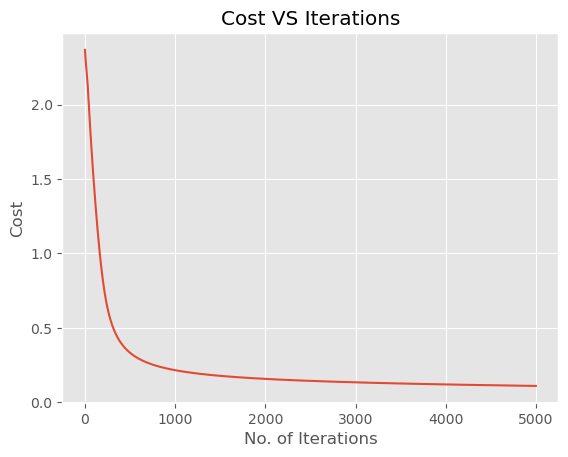

In [18]:
cost_vs_iters(J)

# Predicting on the Test Data Set using the final parameters 

In [25]:
pred_test = predict(X_test_norm, final_parameters, activation)
df_t = pd.DataFrame(pred_test, columns = ['Predictions'])
df_t

,Predictions
0,0
1,4
2,5
3,5
4,6
...,...
9995,9
9996,9
9997,0
9998,8


In [26]:
df_t.to_csv('Neural_pred.csv')